# Time Workbook

- to work on collecting data about how much game time each team has in each game situation
    - tied, +/- 1, +/- 2, +/- 3 or more

In [1]:
# Dependencies
import os
import csv
import pandas as pd
import numpy as np
import sqlite3
from datetime import timedelta
from collections import defaultdict


# Filepaths, libraries, and other variables
db_path = '../../data/db/Dec_3_Current_YTD_Game_Stats.db' # Current YTD Game Stats

# Connect to the database
conn = sqlite3.connect(db_path)
c = conn.cursor()


In [2]:
# List the tables in the database
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

# Get the column names for the scoring_summary table
c.execute("SELECT * FROM scoring_summary")
colnames = [description[0] for description in c.description]
print(colnames)

[('goalie_stats',), ('line_chart',), ('advanced_metrics',), ('game_details',), ('player_stats',), ('linescore',), ('penalty_summary',), ('scoring_summary',), ('player_stats_ytd',), ('master_roster',)]
['Period', 'Team', 'PP', 'Player', 'Player_Goals', 'Assist1', 'Assist2', 'Time', 'Game_ID']


In [3]:
############ temp ############


# OUTPUT CSV OF player_stats_ytd
c.execute("SELECT * FROM player_stats_ytd")
colnames = [description[0] for description in c.description]

with open('../../TEMP/player_stats_ytd.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(colnames)
    for row in c.fetchall():
        writer.writerow(row)

## Create column in table for minutes elapsed 

In [163]:
def convert_time(period, time_str):
    mins, secs = map(int, time_str.split(':'))
    time_left = timedelta(minutes=mins, seconds=secs)
    period_duration = timedelta(minutes=20)

    if '1st' in period:
        elapsed_time = period_duration - time_left
    elif '2nd' in period:
        elapsed_time = (2 * period_duration) - time_left
    elif '3rd' in period:
        elapsed_time = (3 * period_duration) - time_left
    elif 'OT' in period:
        # Overtime starts after 60 minutes and lasts for 5 minutes
        elapsed_time = timedelta(minutes=60) + time_left
    else:
        elapsed_time = timedelta(minutes=60) + time_left  # Default case, assuming overtime

    total_minutes = elapsed_time.total_seconds() / 60
    return total_minutes


In [164]:
# Load the entire scoring_summary table
query_full = "SELECT * FROM scoring_summary;"
scoring_summary_full = pd.read_sql(query_full, conn)

# Apply the convert_time function to the Period and Time columns
scoring_summary_full['Time Elapsed (min)'] = scoring_summary_full.apply(lambda row: convert_time(row['Period'], row['Time']), axis=1)

# # Hotfix try to fix the bug with Minnesota-Duluth - Replace any instance of 'Minnesota-Duluth' with 'Minnesota Duluth'
# # in Game_ID column
# scoring_summary_full['Game_ID'] = scoring_summary_full['Game_ID'].str.replace('Minnesota-Duluth', 'Minnesota Duluth')
# # scoring_summary_full = scoring_summary_full.replace('Minnesota-Duluth', 'Minnesota Duluth')

# Teams with hyphens in their names
teams_with_hyphens = ['Minnesota-Duluth', 'Mass.-Lowell', 'Alaska-Anchorage']

# Replace hyphens in these team names within the Game_ID column
for team in teams_with_hyphens:
    scoring_summary_full['Game_ID'] = scoring_summary_full['Game_ID'].str.replace(team, team.replace('-', ' '))

# Replace bad values in the Team Column - Duluth to Minnesota Duluth, Lowell to Mass Lowell, Anchorage to Alaska Anchorage
scoring_summary_full['Team'] = scoring_summary_full['Team'].str.replace('Duluth', 'Minnesota Duluth')
scoring_summary_full['Team'] = scoring_summary_full['Team'].str.replace('Lowell', 'Mass Lowell')
scoring_summary_full['Team'] = scoring_summary_full['Team'].str.replace('Anchorage', 'Alaska Anchorage')

# Check the results - find rows where the Game_ID column contains 'Minnesota Duluth'
scoring_summary_full[scoring_summary_full['Game_ID'].str.contains('Minnesota Duluth')]
# scoring_summary_full.head(10)

,Period,Team,PP,Player,Player_Goals,Assist1,Assist2,Time,Game_ID,Time Elapsed (min)
100,1st Period,Minnesota Duluth,,Luke Loheit,1,Owen Gallatin,Quinn Olson,6:29,2023-10-07-Michigan Tech-Minnesota Duluth,13.516667
101,2nd Period,Michigan Tech,,Ryland Mosley,1,Max Koskipirtti,Kyle Kukkonen,1:07,2023-10-07-Michigan Tech-Minnesota Duluth,38.883333
102,3rd Period,Minnesota Duluth,,Anthony Menghini,1,Aaron Pionk,Jack Smith,3:16,2023-10-07-Michigan Tech-Minnesota Duluth,56.733333
103,3rd Period,Michigan Tech,,Patriks Marcinkevics,1,Jed Pietila,Blake Pietila,10:13,2023-10-07-Michigan Tech-Minnesota Duluth,49.783333
322,1st Period,Minnesota Duluth,5x3,Ben Steeves,1,Dominic James,Owen Gallatin,13:52,2023-10-13-Northern Michigan-Minnesota Duluth,6.133333
...,...,...,...,...,...,...,...,...,...,...
2608,3rd Period,Minnesota Duluth,,Luke Loheit,4,Connor McMenamin,None,1:05,2023-12-01-Omaha-Minnesota Duluth,58.916667
2609,3rd Period,Omaha,,Jack Randl,3,Joaquim Lemay,Ty Mueller,1:22,2023-12-01-Omaha-Minnesota Duluth,58.633333
2610,3rd Period,Minnesota Duluth,,Connor McMenamin,3,Luke Loheit,Carter Loney,12:59,2023-12-01-Omaha-Minnesota Duluth,47.016667
2611,3rd Period,Minnesota Duluth,EN,Quinn Olson,3,Kyle Bettens,None,18:57,2023-12-01-Omaha-Minnesota Duluth,41.050000


## Track the cumlative score for each game

In [165]:
from collections import defaultdict

def track_scores_with_overtime(df):
    game_scores = defaultdict(lambda: {
        'home': {'team': '', 'score': 0, 'situations': []},
        'away': {'team': '', 'score': 0, 'situations': []}
    })

    for index, row in df.iterrows():
        game_id = row['Game_ID']
        team = row['Team']
        time = row['Time Elapsed (min)']

        # Determine the home and away teams if not already done
        if not game_scores[game_id]['home']['team']:
            game_scores[game_id]['home']['team'] = game_id.split('-')[4]  # Assuming the home team is the third element
            game_scores[game_id]['away']['team'] = game_id.split('-')[3]  # Assuming the away team is the second element

        # Update the score
        if team == game_scores[game_id]['home']['team']:
            game_scores[game_id]['home']['score'] += 1
        else:
            game_scores[game_id]['away']['score'] += 1

        # Update the situations for both home and away teams
        for team_type in ['home', 'away']:
            current_score = game_scores[game_id][team_type]['score']
            other_score = game_scores[game_id]['away' if team_type == 'home' else 'home']['score']
            score_diff = current_score - other_score

            if score_diff == 0:
                situation = 'tied'
            elif score_diff > 0:
                situation = f'+{score_diff} goal' if score_diff == 1 else f'+{score_diff} goals'
            else:
                situation = f'{score_diff} goal' if score_diff == -1 else f'{score_diff} goals'

            game_scores[game_id][team_type]['situations'].append((situation, time))

    # Handle overtime situations
    for game_id, game_data in game_scores.items():
        for team_type in ['home', 'away']:
            last_situation, last_time = game_data[team_type]['situations'][-1]
            if last_time < 60.0:  # If the last recorded time is before the end of regulation
                game_data[team_type]['situations'].append((last_situation, 65.0))  # Extend to the end of overtime

    return game_scores

# Apply the updated function to track scores and situations with overtime consideration
game_scores_with_overtime = track_scores_with_overtime(scoring_summary_full)


In [166]:
# # Assuming scoring_summary_full is your DataFrame containing the scoring summary
# scoring_summary_full['Time Elapsed (min)'] = scoring_summary_full.apply(
#     lambda row: convert_time(row['Period'], row['Time']), axis=1
# )

# # Now call the track_scores_with_overtime function with the updated DataFrame
# game_scores_with_overtime = track_scores_with_overtime(scoring_summary_full)


In [167]:
# Reviewing the tracked scores for the first two games
list(game_scores_with_overtime.items())[52:100]




[('2023-10-13-St. Cloud State-Minnesota State',
  {'home': {'team': 'Minnesota State',
    'score': 3,
    'situations': [('-1 goal', 12.933333333333334),
     ('-2 goals', 37.65),
     ('-1 goal', 35.88333333333333),
     ('tied', 27.216666666666665),
     ('+1 goal', 63.166666666666664)]},
   'away': {'team': 'St. Cloud State',
    'score': 2,
    'situations': [('+1 goal', 12.933333333333334),
     ('+2 goals', 37.65),
     ('+1 goal', 35.88333333333333),
     ('tied', 27.216666666666665),
     ('-1 goal', 63.166666666666664)]}}),
 ('2023-10-13-Northern Michigan-Minnesota Duluth',
  {'home': {'team': 'Minnesota Duluth',
    'score': 5,
    'situations': [('+1 goal', 6.133333333333334),
     ('+2 goals', 5.883333333333334),
     ('+3 goals', 3.3333333333333335),
     ('+2 goals', 38.15),
     ('+1 goal', 35.5),
     ('tied', 33.733333333333334),
     ('+1 goal', 22.35),
     ('tied', 51.766666666666666),
     ('-1 goal', 49.766666666666666),
     ('tied', 42.96666666666667),
     ('t

### This block create dictionary that stores all + or - values up to +6 for example with Michigan State
- works 

In [168]:
def aggregate_detailed_team_stats(game_scores):
    team_stats = defaultdict(lambda: {
        'home': defaultdict(float, {'games': 0}), 
        'away': defaultdict(float, {'games': 0}), 
        'total': defaultdict(float, {'games': 0})
    })
# Hotfix try to fix the bug with Minnesota-Duluth - Replace any instance of 'Minnesota-Duluth' with 'Minnesota Duluth'


    for game_id, game_data in game_scores.items():
        home_team = game_id.split('-')[4]
        away_team = game_id.split('-')[3]

        for team_type, team_name in [('home', home_team), ('away', away_team)]:
            situations = game_data[team_type]['situations']
            team_stats[team_name][team_type]['games'] += 1
            team_stats[team_name]['total']['games'] += 1

            for i in range(len(situations) - 1):
                current_situation, current_time = situations[i]
                next_time = situations[i + 1][1]

                duration = next_time - current_time
                if team_type == 'home':
                    adjusted_situation = current_situation
                else:
                    # Adjusting the situation for away team
                    adjusted_situation = current_situation.replace('+/-', '-')
                team_stats[team_name][team_type][adjusted_situation] += duration
                team_stats[team_name]['total'][adjusted_situation] += duration

            last_situation, last_time = situations[-1]
            end_time = 65.0 if 'OT' in game_id else 60.0
            duration = end_time - last_time
            if team_type == 'home':
                adjusted_situation = last_situation
            else:
                adjusted_situation = last_situation.replace('+/-', '-')
            team_stats[team_name][team_type][adjusted_situation] += duration
            team_stats[team_name]['total'][adjusted_situation] += duration

    return team_stats

# Apply the function to the game scores data
detailed_team_statistics = aggregate_detailed_team_stats(game_scores_with_overtime)  # Replace 'game_scores_data' with your actual data variable


# Displaying the results for the first two teams
list(detailed_team_statistics.items())[:2]


[('Michigan State',
  {'home': defaultdict(float,
               {'games': 8,
                '+1 goal': 173.56666666666672,
                '+2 goals': 113.40000000000002,
                '+3 goals': 8.416666666666668,
                'tied': 70.88333333333333,
                '+4 goals': 22.68333333333333,
                '-1 goal': 13.616666666666667}),
   'away': defaultdict(float,
               {'games': 8,
                '-1 goal': 8.483333333333327,
                '-2 goals': 49.65000000000001,
                '-3 goals': 0.33333333333333215,
                '-4 goals': 14.833333333333332,
                '+1 goal': 27.21666666666667,
                '+2 goals': 43.0,
                '+3 goals': 20.78333333333333,
                'tied': 208.33333333333331,
                '+4 goals': -0.13333333333333286,
                '+5 goals': -9.983333333333327,
                '+6 goals': 18.68333333333333}),
   'total': defaultdict(float,
               {'games': 16,
               

In [169]:
def get_score_diff_value(diff_string):
    try:
        return int(diff_string.split(' ')[1])
    except (ValueError, IndexError):
        return 0

rows = []
for team, data in detailed_team_statistics.items():
    row = {'Team Name': team}
    for location in ['home', 'away', 'total']:
        row.update({f'{location} {key}': value for key, value in data[location].items()})

        # Calculating columns for aggregate time leading/trailing by 3 or more goals
        leading_3_or_more = sum([v for k, v in data[location].items() if k.startswith('+') and get_score_diff_value(k) >= 3])
        trailing_3_or_more = sum([v for k, v in data[location].items() if k.startswith('-') and get_score_diff_value(k) <= -3])
        row[f'{location} +3 or more goals'] = leading_3_or_more
        row[f'{location} -3 or more goals'] = trailing_3_or_more

    rows.append(row)

detailed_team_stats_df = pd.DataFrame(rows)

# Display the first few rows of the DataFrame
detailed_team_stats_df.head()

# # Check for any unusual values in the input data for 'Northern Michigan'
# nm_data = detailed_team_statistics.get('Northern Michigan', {})
# print("Northern Michigan Data:", nm_data)


,Team Name,home games,home +1 goal,home +2 goals,home +3 goals,home tied,home +4 goals,home -1 goal,home +3 or more goals,home -3 or more goals,...,home +8 goals,home +9 goals,total +7 goals,total +8 goals,total +9 goals,away +7 goals,away +8 goals,away -9 goals,total -9 goals,home -8 goals
0,Michigan State,8,173.566667,113.400000,8.416667,70.883333,22.683333,13.616667,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lake Superior,8,13.000000,110.883333,-11.700000,121.266667,16.983333,141.966667,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Notre Dame,11,52.950000,64.300000,115.983333,75.683333,-21.866667,12.983333,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Clarkson,8,137.616667,6.433333,58.783333,75.400000,NaN,20.250000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,St. Lawrence,9,73.933333,32.083333,19.433333,136.783333,NaN,120.600000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
# Info
# detailed_team_stats_df.info()

# show the row that has data in this column total +10 goals 
# detailed_team_stats_df[detailed_team_stats_df['total +10 goals'] > 0]

In [171]:
## Sample

detailed_team_stats_df.sample(10)

# find any columns that are all 0 
test = detailed_team_stats_df.loc[:, (detailed_team_stats_df == 0).all(axis=0)]
drop_cols = test.columns
detailed_team_stats_df.drop(drop_cols, axis=1, inplace=True) #drop columns that are all 0




# Examine

# Histogram of Home Games
# detailed_team_stats_df['Total Tied'].hist()


##### Calculate Total Minutes for Home, Away and Total

In [172]:
# Calculate total minutes for home, away, and total games
detailed_team_stats_df['Home Total Minutes'] = detailed_team_stats_df[[col for col in detailed_team_stats_df.columns if 'home +' in col or 'home -' in col]].sum(axis=1)
detailed_team_stats_df['Away Total Minutes'] = detailed_team_stats_df[[col for col in detailed_team_stats_df.columns if 'away +' in col or 'away -' in col]].sum(axis=1)
detailed_team_stats_df['Total Minutes'] = detailed_team_stats_df[[col for col in detailed_team_stats_df.columns if 'total +' in col or 'total -' in col]].sum(axis=1)


### There are some negative values 
- try just coverting everything to abolute and see if the data is all good - hopeful

In [173]:
# get a list of columns that are numeric
numeric_cols = detailed_team_stats_df.select_dtypes(include=[np.number]).columns.tolist()

## convert any negative numerical values in dataframe to positive using abs()
detailed_team_stats_df[numeric_cols] = detailed_team_stats_df[numeric_cols].abs()

In [174]:
# Save a CSV file
detailed_team_stats_df.to_csv('../../TEMP/team_stats_score_differentialv2.csv', index=False)

### Check for Outliers

In [175]:

# Basic statistics for key columns
basic_stats = detailed_team_stats_df[['home games', 'away games', 'total games', 'Home Total Minutes', 'Away Total Minutes', 'Total Minutes']].describe()

# Check for extreme or implausible values
extreme_values_check = detailed_team_stats_df[['home games', 'away games', 'total games', 'Home Total Minutes', 'Away Total Minutes', 'Total Minutes']].max()

# Display basic stats and check for extreme values
basic_stats, extreme_values_check


(       home games  away games  total games  Home Total Minutes  \
 count   64.000000   64.000000    64.000000           64.000000   
 mean     7.296875    7.296875    14.593750          252.996615   
 std      2.090642    1.965413     2.106066           92.471977   
 min      3.000000    4.000000     9.000000           24.466667   
 25%      6.000000    6.000000    14.000000          195.645833   
 50%      8.000000    7.000000    15.000000          265.491667   
 75%      9.000000    8.250000    16.000000          312.691667   
 max     12.000000   12.000000    18.000000          448.583333   
 
        Away Total Minutes  Total Minutes  
 count           64.000000      64.000000  
 mean           252.996615     505.993229  
 std             98.312503     120.096398  
 min             49.283333     192.433333  
 25%            181.366667     458.229167  
 50%            260.383333     504.175000  
 75%            305.545833     596.162500  
 max            463.750000     735.766667  

# Simple Visualizations and Exploration

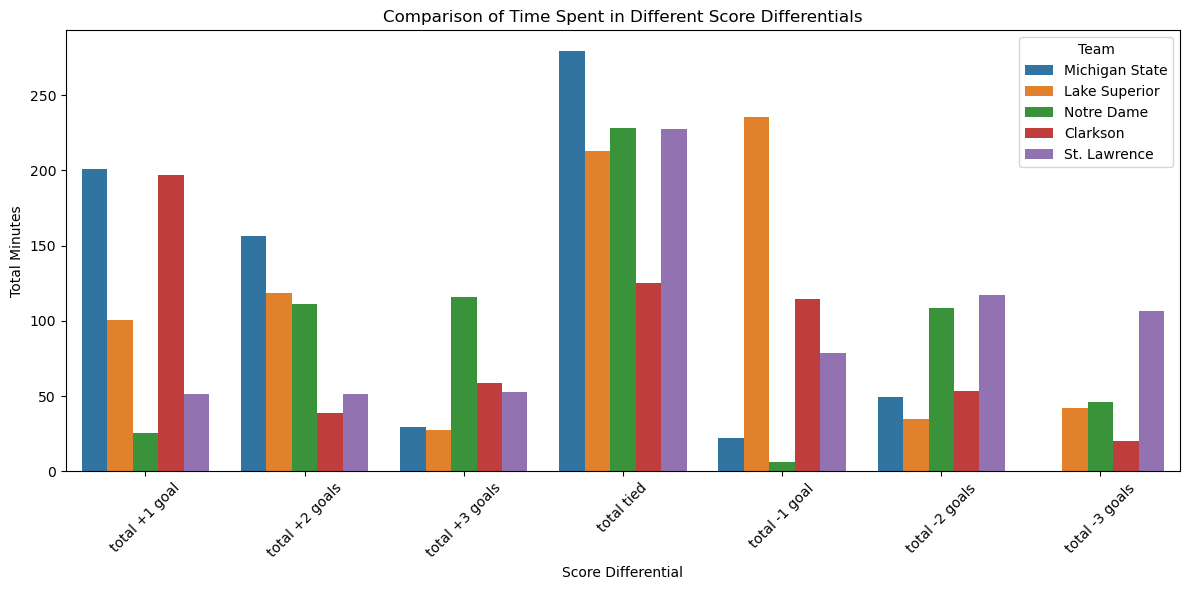

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few teams for comparison, including Michigan State and Notre Dame
teams_for_comparison = ['Michigan State', 'Notre Dame', 'Lake Superior', 'Clarkson', 'St. Lawrence']
comparison_data = detailed_team_stats_df[detailed_team_stats_df['Team Name'].isin(teams_for_comparison)]

# Preparing data for visualization - focusing on total time in different score differentials
score_differentials = ['+1 goal', '+2 goals', '+3 goals', 'tied', '-1 goal', '-2 goals', '-3 goals']
columns_of_interest = [f'total {diff}' for diff in score_differentials]

# Reshaping data for grouped bar chart
reshaped_data = comparison_data.melt(id_vars=['Team Name'], value_vars=columns_of_interest, var_name='Situation', value_name='Minutes')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Situation', y='Minutes', hue='Team Name', data=reshaped_data)
plt.title('Comparison of Time Spent in Different Score Differentials')
plt.xticks(rotation=45)
plt.ylabel('Total Minutes')
plt.xlabel('Score Differential')
plt.legend(title='Team')
plt.tight_layout()

plt.show()


# Calculate the percentage of total time for each team in each different situation
# Binning together scores of leading or trailing by 3 or more goals

In [177]:
# Calculate the percentage of total time for each team in each different situation
# Binning together scores of leading or trailing by 3 or more goals

# Add columns for combined leading/trailing by 3 or more goals
detailed_team_stats_df['total +3 or more goals'] = detailed_team_stats_df.filter(regex='total \+\d+ goals').sum(axis=1)
detailed_team_stats_df['total -3 or more goals'] = detailed_team_stats_df.filter(regex='total -\d+ goals').sum(axis=1)

# Calculate percentage of total time in each situation
score_situations = ['+1 goal', '+2 goals', '+3 or more goals', 'tied', '-1 goal', '-2 goals', '-3 or more goals']
for situation in score_situations:
    detailed_team_stats_df[f'% total {situation}'] = (detailed_team_stats_df[f'total {situation}'] / detailed_team_stats_df['total games']) * 100

# ## UGLY INECESSARY BAR CHART
# # Filter for selected teams
# selected_teams_df = detailed_team_stats_df[detailed_team_stats_df['Team Name'].isin(teams_for_comparison)]

# # Reshape for visualization
# reshaped_percentage_data = selected_teams_df.melt(id_vars=['Team Name'], value_vars=[f'% total {situation}' for situation in score_situations], var_name='Situation', value_name='Percentage')

# # Plotting
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Situation', y='Percentage', hue='Team Name', data=reshaped_percentage_data)
# plt.title('Percentage of Total Time Spent in Different Score Situations')
# plt.xticks(rotation=45)
# plt.ylabel('Percentage of Total Time (%)')
# plt.xlabel('Score Situation')
# plt.legend(title='Team')
# plt.tight_layout()

# plt.show()



In [178]:
# # Create pie charts for each specified team: Michigan State, Notre Dame, Boston College, and Stonehill
# specified_teams = ['Michigan State', 'Notre Dame', 'Boston College', 'Stonehill']
# specified_teams_df = detailed_team_stats_df[detailed_team_stats_df['Team Name'].isin(specified_teams)]

# # Prepare data for pie charts
# pie_data = specified_teams_df.set_index('Team Name')[[f'% total {situation}' for situation in score_situations]]

# # Plotting pie charts for each team
# fig, axes = plt.subplots(1, len(specified_teams), figsize=(20, 5))
# # fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# fig.suptitle('Distribution of Game Time in Different Score Situations')

# for i, team in enumerate(specified_teams):
#     ax = axes[i]
#     team_data = pie_data.loc[team].dropna()
#     ax.pie(team_data, labels=team_data.index, autopct='%1.1f%%', startangle=140)
#     ax.set_title(team)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()



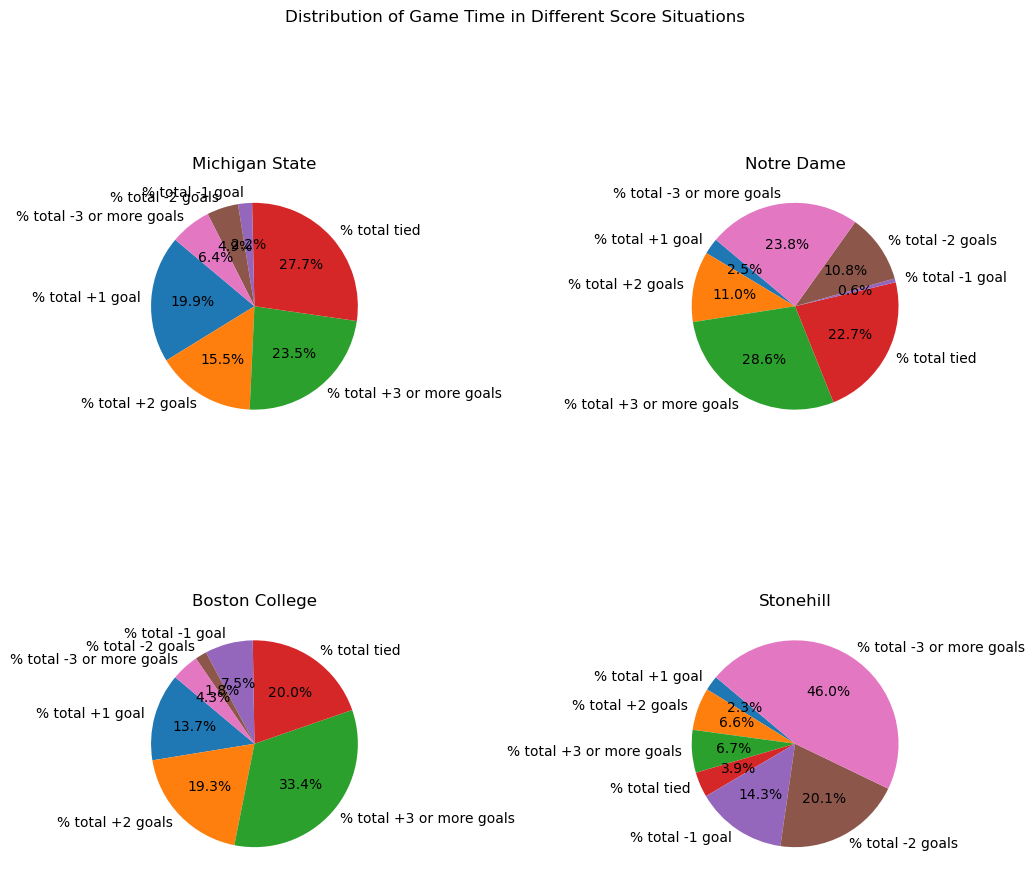

In [179]:
# Plotting pie charts for each team in a 2x2 grid layout
num_rows = 2  # Number of rows in the grid
num_cols = 2  # Number of columns in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Adjust the figure size as needed
fig.suptitle('Distribution of Game Time in Different Score Situations')

for i, team in enumerate(specified_teams):
    ax = axes[i // num_cols, i % num_cols]  # Determine the position of the subplot
    team_data = pie_data.loc[team].dropna()
    # Filter out negative values
    team_data = team_data[team_data > 0]
    ax.pie(team_data, labels=team_data.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(team)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


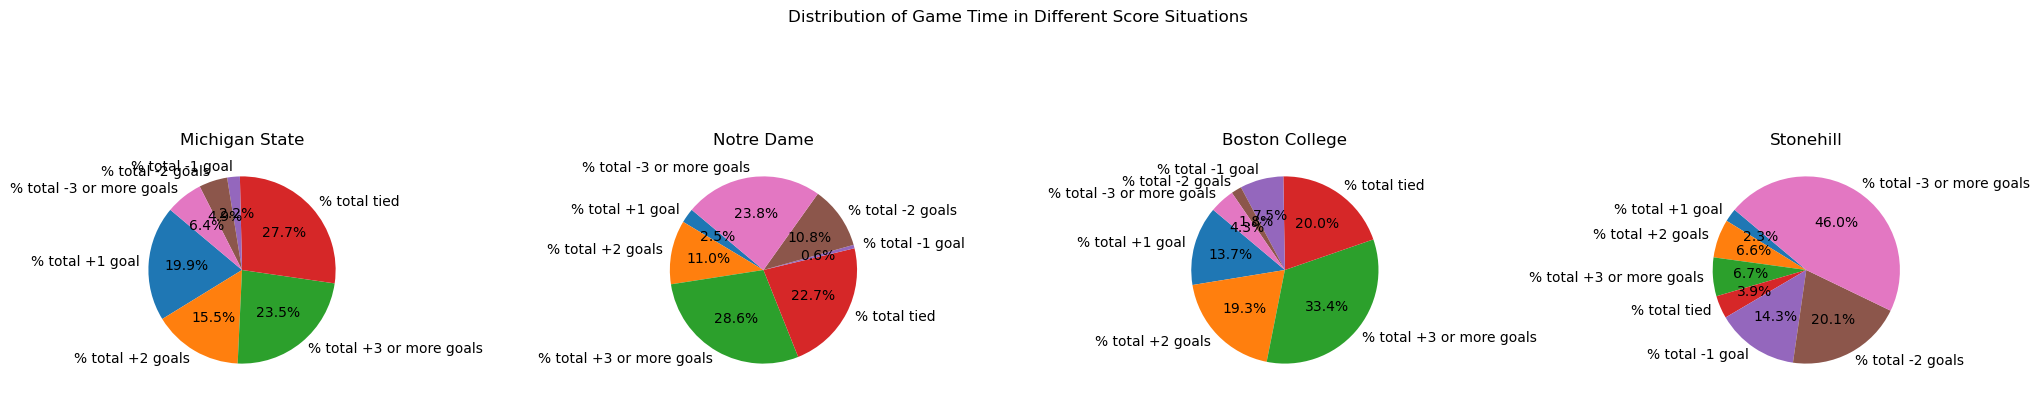

In [180]:
# Create pie charts for each specified team: Michigan State, Notre Dame, Boston College, and Stonehill
specified_teams = ['Michigan State', 'Notre Dame', 'Boston College', 'Stonehill']
specified_teams_df = detailed_team_stats_df[detailed_team_stats_df['Team Name'].isin(specified_teams)]

# Prepare data for pie charts
pie_data = specified_teams_df.set_index('Team Name')[[f'% total {situation}' for situation in score_situations]]

# Plotting pie charts for each team
fig, axes = plt.subplots(1, len(specified_teams), figsize=(20, 5))
fig.suptitle('Distribution of Game Time in Different Score Situations')

for i, team in enumerate(specified_teams):
    ax = axes[i]
    team_data = pie_data.loc[team].dropna()
    ax.pie(team_data, labels=team_data.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(team)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

